# Importy

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

___
# Testy 

In [4]:
def normality_tests(data):
    # Parametry dla rozkładu normalnego
    loc, sc = st.norm.fit(data)

    # Test Kolmogorova-Smirnova
    ks_result = st.kstest(data, 'norm', args=(loc, sc))
    ks_stat, ks_p_value = ks_result.statistic, ks_result.pvalue
    
    # Test normalności (D'Agostino i Pearson)
    normaltest_stat, normaltest_p_value = st.normaltest(data)

    # Test Shapiro-Wilka
    shapiro_stat, shapiro_p_value = st.shapiro(data)
    print(shapiro_stat,shapiro_p_value)
    
    # Interpretacja wyników
    print("Test Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu normalnego.")
    
    print("\nTest D'Agostino i Pearson:")
    print(f"Statystyka: {normaltest_stat:.4f}, p-wartość: {normaltest_p_value:.4f}")
    print("Wynik testu D'Agostino i Pearson:")
    if normaltest_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")
    
    print("\nTest Shapiro-Wilka:")
    print(f"Statystyka: {shapiro_stat:.4f}, p-wartość: {shapiro_p_value:.4f}")
    print("Wynik testu Shapiro-Wilka:")
    if shapiro_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")

In [5]:
def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")

___
# Miedź

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


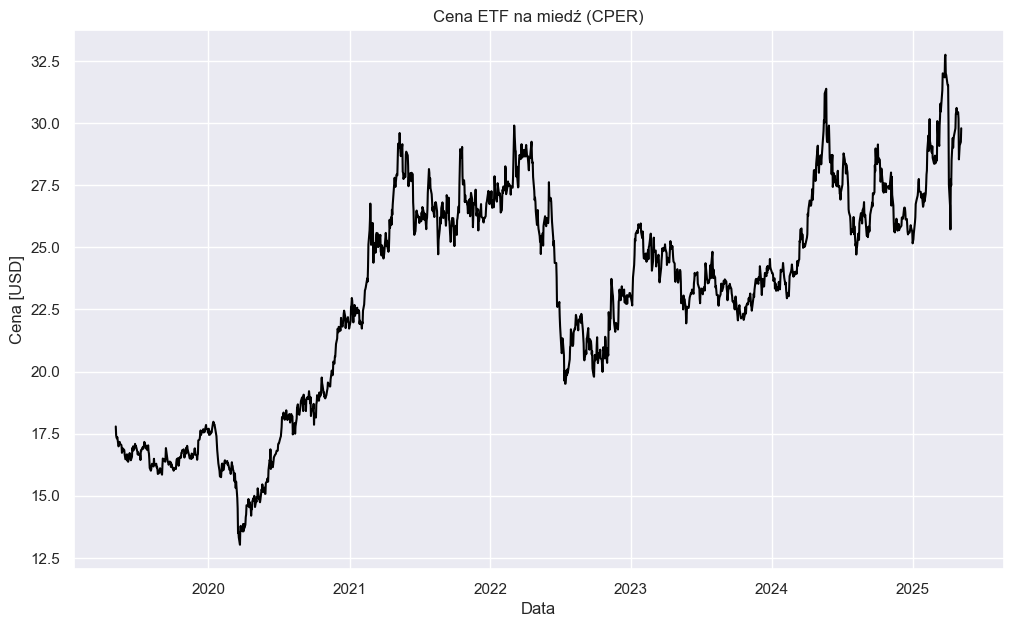

In [6]:
copper = yf.download('CPER', period='6y')['Close']

plt.plot(copper, color = 'black')
plt.title('Cena ETF na miedź (CPER)')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

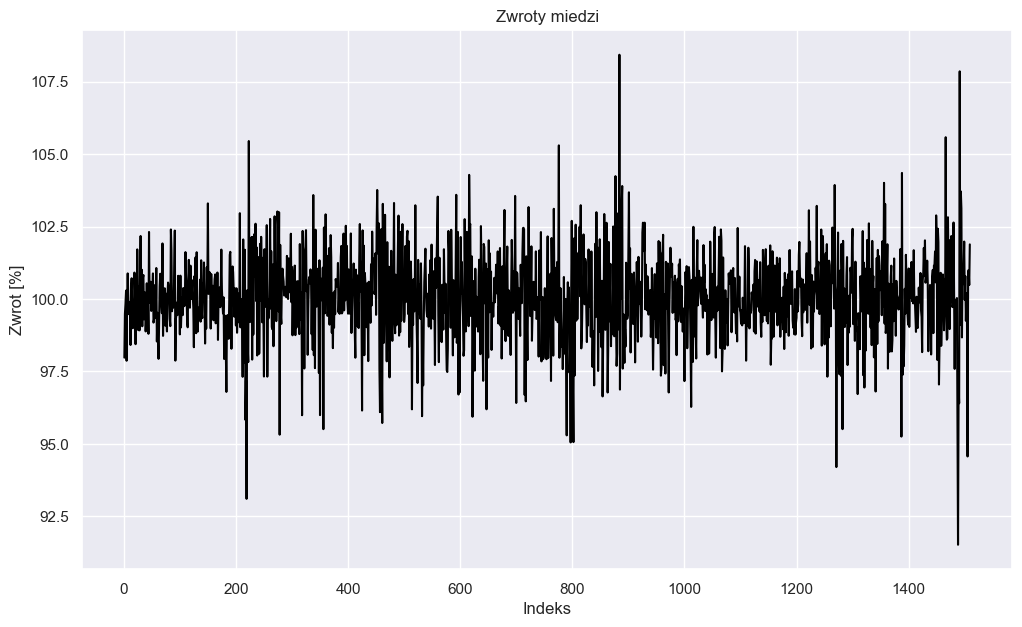

In [7]:
log_returns_copper = copper / copper.shift(1).dropna()
log_returns_copper = 100*np.ravel(log_returns_copper)
plt.plot(log_returns_copper, color = 'black')
plt.title('Zwroty miedzi')
plt.ylabel('Zwrot [%]')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

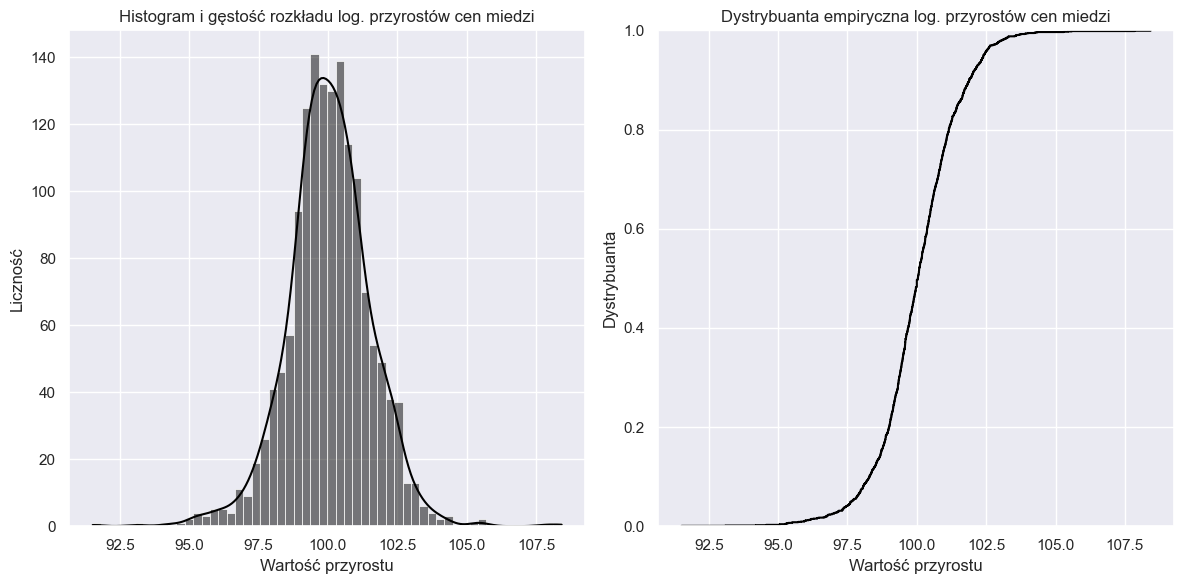

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_copper, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen miedzi')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_copper, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen miedzi')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

# Metoda parametryczna